d-sandbox

<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="https://databricks.com/wp-content/uploads/2018/03/db-academy-rgb-1200px.png" alt="Databricks Learning" style="width: 600px">
</div>

# Continuing with Spark and Data Science
## Module 4, Lesson 6

## ![Spark Logo Tiny](https://files.training.databricks.com/images/105/logo_spark_tiny.png) In this lesson you:
* Build a Machine Learning model using scikit-learn
* Predict the response time to an incident given different features

In [0]:
%run ../Includes/Classroom-Setup

Data mounted to /mnt/davis ...

## Load Data

We are going to build a model on a subset of our data.

In [0]:
%sql
USE DATABRICKS;

CREATE TABLE IF NOT EXISTS fireCallsClean
USING parquet
OPTIONS (
  path "/mnt/davis/fire-calls/fire-calls-clean.parquet"
)

## Timestamp

Let's convert our `Response_DtTm` and `Received_DtTm` into timestamp types. `Response_DtTm` is when an incident is solved where as `Received_DtTm` is when an incident is reported.

In [0]:
%sql
CREATE OR REPLACE VIEW time AS (
  SELECT *, unix_timestamp(Response_DtTm, "MM/dd/yyyy hh:mm:ss a") as ResponseTime, 
            unix_timestamp(Received_DtTm, "MM/dd/yyyy hh:mm:ss a") as ReceivedTime
  FROM fireCallsClean
)

## Time Delay

Now that we have our `Response_DtTm` and `Received_DtTm` as timestamp types, we can compute the difference in minutes between the two.

In [0]:
%sql
CREATE OR REPLACE VIEW timeDelay AS (
  SELECT *, (ResponseTime - ReceivedTime)/60 as timeDelay
  FROM time
)

Uh oh! We have some records with a negative time delay, and some with very extreme values. We will filter out those records.

In [0]:
%sql
SELECT timeDelay, Call_Type, Fire_Prevention_District, `Neighborhooods_-_Analysis_Boundaries`, Unit_Type
FROM timeDelay 
WHERE timeDelay < 0

timeDelay,Call_Type,Fire_Prevention_District,Neighborhooods_-_Analysis_Boundaries,Unit_Type
-58.233333333333334,Structure Fire,5,Hayes Valley,ENGINE
-49.333333333333336,Medical Incident,1,Financial District/South Beach,TRUCK
-56.016666666666666,Medical Incident,2,Potrero Hill,ENGINE
-57.416666666666664,Structure Fire,4,Tenderloin,TRUCK
-56.06666666666667,Medical Incident,2,Tenderloin,MEDIC
-1.2,Alarms,3,Mission Bay,ENGINE


Great! Our data is prepared and ready to be used to build a model!

In [0]:
%sql
SELECT timeDelay, Call_Type, Fire_Prevention_District, `Neighborhooods_-_Analysis_Boundaries`, Unit_Type
FROM timeDelay 
WHERE timeDelay < 15 AND timeDelay > 0 LIMIT 5

timeDelay,Call_Type,Fire_Prevention_District,Neighborhooods_-_Analysis_Boundaries,Unit_Type
2.3666666666666667,Traffic Collision,10,Bayview Hunters Point,MEDIC
2.433333333333333,Medical Incident,2,South of Market,ENGINE
3.816666666666667,Medical Incident,2,Mission,MEDIC
7.75,Medical Incident,10,Portola,ENGINE
0.8833333333333333,Structure Fire,8,Sunset/Parkside,ENGINE


## Convert to Pandas DataFrame

We are going to convert our Spark DataFrame to a Pandas DataFrame to build a scikit-learn model. Although we could use SparkML to train models, a lot of data scientists start by building their models using Pandas and Scikit-Learn.

We will also enable [Apache Arrow](https://spark.apache.org/docs/latest/sql-pyspark-pandas-with-arrow.html) for faster transfer of data from Spark DataFrames to Pandas DataFrames.

In [0]:
%python
pdDF = sql("""SELECT timeDelay, Call_Type, Fire_Prevention_District, `Neighborhooods_-_Analysis_Boundaries`, Unit_Type
              FROM timeDelay 
              WHERE timeDelay < 15 AND timeDelay > 0""").toPandas()

**Let us read the first few rows of the dataframe**

In [0]:
pdDF.head(5)

,timeDelay,Call_Type,Fire_Prevention_District,Neighborhooods_-_Analysis_Boundaries,Unit_Type
0,2.366667,Traffic Collision,10,Bayview Hunters Point,MEDIC
1,2.433333,Medical Incident,2,South of Market,ENGINE
2,3.816667,Medical Incident,2,Mission,MEDIC
3,7.750000,Medical Incident,10,Portola,ENGINE
4,0.883333,Structure Fire,8,Sunset/Parkside,ENGINE


## Visualize

Let's visualize the distribution of our time delay.

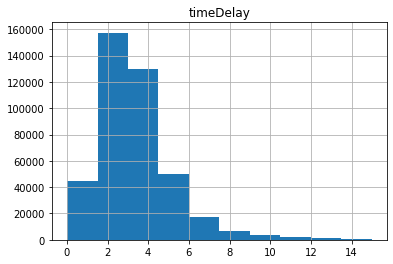

In [0]:
%python
import pandas as pd
import numpy as np

fig = pdDF.hist(column="timeDelay")[0][0]


## Train-Test Split

In this notebook we are going to use 80% of our data to train our model, and 20% to test our model. We set a [random_state](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for reproducibility.

In [0]:
%python
from sklearn.model_selection import train_test_split

X = pdDF.drop("timeDelay", axis=1)
y = pdDF["timeDelay"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline Model

Before we get started building our linear regression model, let's establish our baseline RMSE on our test dataset by always predicting the average value. Here, we are going to take the square root of the [MSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html).

In [0]:
%python
from sklearn.metrics import mean_squared_error
import numpy as np

avgDelay = np.full(y_test.shape, np.mean(y_train), dtype=float)

print("RMSE is {0}".format(np.sqrt(mean_squared_error(y_test, avgDelay))))

RMSE is 1.8348773381102907


## Build Linear Regression Model

Great! Now that we have established a baseline, let's use scikit-learn's [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) API to build a linear regression model.

Our pipeline will have two steps: 
0. [One Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder): this converts our categorical features into numeric features by creating a dummy column for each value in that category. 
    * For example, if we had a column called `Animal` with the values `Dog`, `Cat`, and `Bear`, the corresponding one hot encoding representation for Dog would be: `[1, 0, 0]`, Cat: `[0, 1, 0]`, and Bear: `[0, 0, 1]`
0. [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model: find the line of best fit for our training data

In [0]:
%python
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

ohe = ("ohe", OneHotEncoder(handle_unknown="ignore"))
lr = ("lr", LinearRegression(fit_intercept=True, normalize=True))

pipeline = Pipeline(steps = [ohe, lr]).fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

You can see the corresponding one hot encoded feature names below.

In [0]:
%python
print(pipeline.steps[0][1].get_feature_names())

Take a look at the highest coefficients.  These are the features that have the highest impact on our final prediction.

In [0]:
%python
coefs = pd.DataFrame([pipeline.steps[0][1].get_feature_names(), pipeline.steps[1][1].coef_]).T
coefs.columns = ["features", "coef"]
coefs = coefs.sort_values("coef", ascending=False)

coefs.head(10)

,features,coef
86,x3_INVESTIGATION,3.721116
29,x0_Watercraft in Distress,3.551014
12,x0_HazMat,2.115506
24,x0_Suspicious Package,2.086519
13,x0_High Angle Rescue,1.940764
83,x3_AIRPORT,1.824633
15,x0_Marine Fire,1.758124
9,"x0_Extrication / Entrapped (Machinery, Vehicle)",1.501484
28,x0_Water Rescue,1.168056
26,x0_Train / Rail Incident,1.108696


Now look at the lowest coefficients

In [0]:
%python
coefs.sort_values("coef", ascending=True).head(10)

,features,coef
23,x0_Structure Fire,-1.150849
91,x3_SUPPORT,-0.368824
25,x0_Traffic Collision,-0.229743
27,x0_Vehicle Fire,-0.200085
0,x0_Administrative,-0.186875
40,x1_None,-0.122064
35,x1_5,-0.119379
59,x2_Mission,-0.097666
2,x0_Alarms,-0.097039
41,x2_Bayview Hunters Point,-0.092642


## Evaluate on Test Data

Let's take a look at our RMSE.

In [0]:
%python
from sklearn.metrics import mean_squared_error

print("RMSE is {0}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

RMSE is 1.784207673763586


## Save Model

Not bad! We did a bit better than our baseline model. 

Let's save this model using MLflow. [MLflow](https://mlflow.org/) is an open-source project created by Databricks to help simplify the Machine Learning life cycle. 

While MLflow is out of the scope of this class, it has a nice function to generate Spark User-Defined Function (UDF) to apply this model in parallel to the rows in our dataset. We will see this in the next notebook.

In [0]:
%python
try:
  import mlflow
  import mlflow.sklearn

  with mlflow.start_run(run_name="Basic Linear Regression Experiment") as run:
    mlflow.sklearn.log_model(pipeline, "Model Pipeline")
except:
  print("ERROR: This cell did not run, likely because you're not running the correct version of software. Please use a cluster with a runtime with `ML` at the end of the version name.")

Now you can click the "Experiment" button at the upper right hand corner of the screen to see where we saved the model.

-sandbox
&copy; 2021 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="http://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="http://help.databricks.com/">Support</a>